# Functional Connectivity Analysis with Nilearn - Rest

This script closely follows [this example](https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html) provided through the Nilearn tutorials site.

In [1]:
from scipy import corrcoef
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn import cluster, metrics
import numpy as np
import pandas as pd
import os

### The Schaefer Local-Global Parcellation

The Schaefer 2018 parcellation is available from the [CBIG GitHub Repo](https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal).

In [2]:
from nilearn import datasets
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2, data_dir='/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer')
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' % atlas_filename)  # 4D data
from nilearn import plotting
plotting.plot_roi(atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


In [3]:
schaefer_coords = np.loadtxt('data/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv', delimiter = ',', skiprows=2, usecols=(2,3,4))
schaefer_coords = tuple(map(tuple, schaefer_coords))
schaefer_coords[:5]


((-36.0, -62.0, -16.0),
 (-24.0, -72.0, -10.0),
 (-36.0, -82.0, -16.0),
 (-16.0, -86.0, -16.0),
 (-24.0, -96.0, -12.0))

### Load task data  
Comparing task to rest.

Right now, I'm only using the second run of MemMatch for testing and because I'm hoping the second run is less sensitive to warm-up effects and memory deterioration from elapsed time.

In [4]:
task = 'REST'

In [5]:
from nipype.interfaces.io import DataFinder

data_dir = '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep'
os.path.isdir(data_dir)

df = DataFinder()
df.inputs.root_paths = data_dir
df.inputs.match_regex = ('%s.+preproc_bold.nii.gz' % task)
df_result = df.run()
fmri_filenames = df_result.outputs.out_paths

conf = DataFinder()
conf.inputs.root_paths = data_dir
conf.inputs.match_regex = ('%s.+regressors.tsv' % task)
conf_result = conf.run()
conf_filenames = conf_result.outputs.out_paths

In [6]:
print(fmri_filenames[:5])

['/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30004/func/sub-30004_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30008/func/sub-30008_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30009/func/sub-30009_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30012/func/sub-30012_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30015/func/sub-30015_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


In [7]:
conf_cols = ['csf', 'white_matter', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement']

For some reason, subject 30274 had an older version of fmriprep so the confounds file wasn't able to be read. This just checks that that subject is no longer in the line up for the time being.
Problems with: 40608, 40658

### Extract timeseries
I'm detrending the data and applying a bandpass filter from 0.08 to 0.1 Hz. Timeseries are organized into an array with all subjects (pooled_subjects), as well as by age group (oa_ts, ya_ts).

Running this for the whole dataset will take some time, so take a coffee break :)

In [11]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, detrend=True, verbose=5, low_pass=0.1, high_pass=0.08, t_r=1.5)

# oa_ts = []
# ya_ts = []
# #pooled_ts = []
# oa_list = []
# ya_list = []
for fmri_file, confound_file in zip(fmri_filenames[82:], conf_filenames[82:]):
    
    confounds = pd.read_csv(confound_file, sep = '\t', usecols = conf_cols)
    confounds['fd_scrub'] = np.where(confounds['framewise_displacement'] > 0.20, 0, 1)
    confounds = confounds.drop(columns = 'framewise_displacement')
    confounds = confounds.values
    
    time_series = masker.fit_transform(fmri_file, confounds=confounds)
    #pooled_ts.append(time_series)
    partic = fmri_file.split('sub-',1)[1]
    partic = partic[0:5]
    if int(partic) >= 40000:
        oa_ts.append(time_series)
        oa_list.append(partic)
    else:
        ya_ts.append(time_series)
        ya_list.append(partic)
    print('Data has {0} OA subjects.'.format(len(oa_ts)))
    print('Data has {0} YA subjects.'.format(len(ya_ts)))

np.save('data/%s_oa_ts' % task, oa_ts)
np.save('data/%s_ya_ts' % task, ya_ts)

np.save('data/%s_oa_list' % task, oa_list)
np.save('data/%s_ya_list' % task, ya_list)

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40664/func/sub-40664_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 30 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40665/func/sub-40665_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 31 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40668/func/sub-40668_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 32 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40672/func/sub-40672_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 33 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40685/func/sub-40685_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 34 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40694/func/sub-40694_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 35 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40720/func/sub-40720_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 36 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40728/func/sub-40728_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 37 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40730/func/sub-40730_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 38 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40738/func/sub-40738_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 39 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40743/func/sub-40743_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 40 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40750/func/sub-40750_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 41 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40758/func/sub-40758_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 42 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40767/func/sub-40767_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 43 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40768/func/sub-40768_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 44 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40769/func/sub-40769_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 45 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40773/func/sub-40773_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 46 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40777/func/sub-40777_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 47 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40778/func/sub-40778_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 48 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40779/func/sub-40779_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 49 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40782/func/sub-40782_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 50 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40784/func/sub-40784_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 51 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40796/func/sub-40796_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 52 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40803/func/sub-40803_task-REST_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 53 OA subjects.
Data has 51 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [12]:
oa_ts = np.load('data/%s_oa_ts.npy' % task)
ya_ts = np.load('data/%s_ya_ts.npy' % task)

### Calculate functional connectivity using full correlation

In [13]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')

correlation_matrices_oa = correlation_measure.fit_transform(oa_ts)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of OA patients are stacked in an array of shape {0}'
      .format(correlation_matrices_oa.shape))

mean_correlation_matrix_oa = correlation_measure.mean_
print('Mean correlation OA has shape {0}.'.format(mean_correlation_matrix_oa.shape))

Correlations of OA patients are stacked in an array of shape (53, 400, 400)
Mean correlation OA has shape (400, 400).


In [14]:
np.save('data/%s_correlation_matrices_oa' % task, correlation_matrices_oa)

In [15]:
correlation_matrices_ya = correlation_measure.fit_transform(ya_ts)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of YA patients are stacked in an array of shape {0}'
      .format(correlation_matrices_ya.shape))

mean_correlation_matrix_ya = correlation_measure.mean_
print('Mean correlation YA has shape {0}.'.format(mean_correlation_matrix_ya.shape))

Correlations of YA patients are stacked in an array of shape (51, 400, 400)
Mean correlation YA has shape (400, 400).


In [16]:
np.save('data/%s_correlation_matrices_ya' % task, correlation_matrices_ya)

### Plot correlation matrices for a handful of subjects

In [17]:
# import numpy as np
# correlation_matrices_oa = np.load('data/correlation_matrices_oa.npy')
# correlation_matrices_ya = np.load('data/correlation_matrices_ya.npy')

In [18]:
import matplotlib.pylab as plt

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

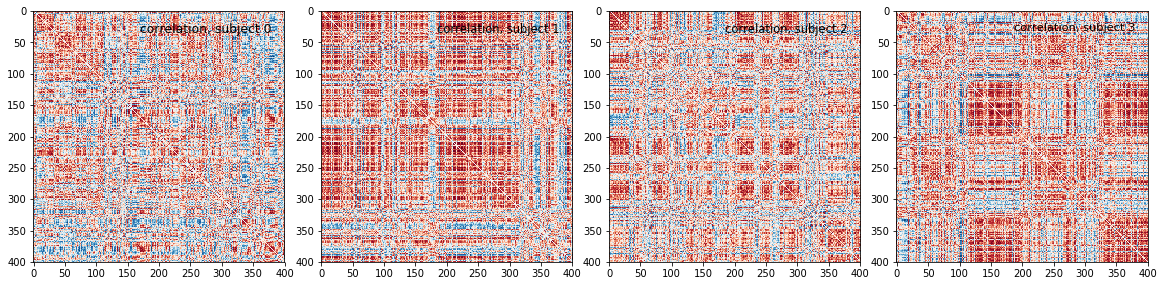

In [19]:
plot_matrices(correlation_matrices_oa[:4], 'correlation')

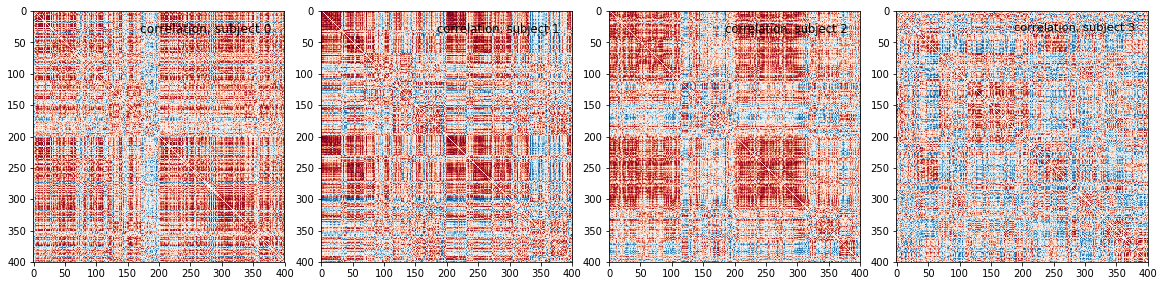

In [20]:
plot_matrices(correlation_matrices_ya[:4], 'correlation')

### Visualize group mean correlation matrices on glass brain

Another good time for a coffee break :)

It's really hard to see the edges since I can't find a way to only show nodes with significant edges.

/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


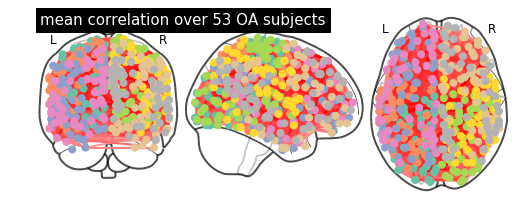

In [21]:
from nilearn import plotting

plotting.plot_connectome(mean_correlation_matrix_oa, schaefer_coords, \
                         title='mean correlation over {0} OA subjects'.format(len(correlation_matrices_oa)), \
                         edge_threshold='90%')


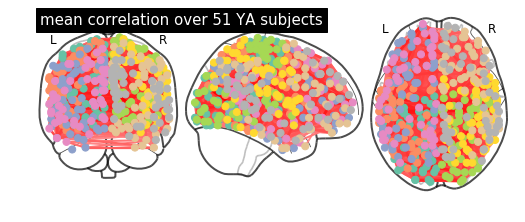

In [22]:
plotting.plot_connectome(mean_correlation_matrix_ya, schaefer_coords, \
                         title='mean correlation over {0} YA subjects'.format(len(correlation_matrices_ya)), \
                         edge_threshold='90%')


### Use the Network-Based Statistic to analyze group functional connectivity differences

Read more about NBS in [Zalesky (2010)](10.1016/j.neuroimage.2010.06.041).

This uses the [Brain Connectivity Toolbox for Python](https://github.com/aestrivex/bctpy).

    x : NxNxP np.ndarray
        matrix representing the first population with P subjects. must be
        symmetric.
    y : NxNxQ np.ndarray
        matrix representing the second population with Q subjects. Q need not
        equal P. must be symmetric.
    thresh : float
        minimum t-value used as threshold
    k : int
        number of permutations used to estimate the empirical null 
        distribution
    tail : {'left', 'right', 'both'}
        enables specification of particular alternative hypothesis
        'left' : mean population of X < mean population of Y
        'right' : mean population of Y < mean population of X
        'both' : means are unequal (default)

In [23]:
X = correlation_matrices_ya.reshape((400, 400, len(correlation_matrices_ya)))
Y = correlation_matrices_oa.reshape((400, 400, len(correlation_matrices_oa)))

In [24]:
from bct import nbs

pval, adj, null = nbs.nbs_bct(X, Y, thresh=20.0, k=3, tail='right', paired=False, verbose=False)

max component size is 16
estimating null distribution with 3 permutations
permutation 0 of 3.  p-value so far is 0.000
permutation 2 of 3.  p-value so far is 0.000


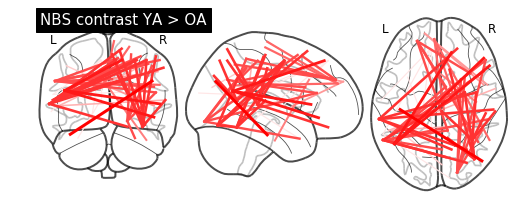

In [25]:
from nilearn import plotting
plotting.plot_connectome(adj, schaefer_coords, title='NBS contrast YA > OA', node_size=0)

In [26]:
pval, adj, null = nbs.nbs_bct(X, Y, thresh=20.0, k=3, tail='left', paired=False, verbose=False)

max component size is 6
estimating null distribution with 3 permutations
permutation 0 of 3.  p-value so far is 0.000
permutation 2 of 3.  p-value so far is 0.000


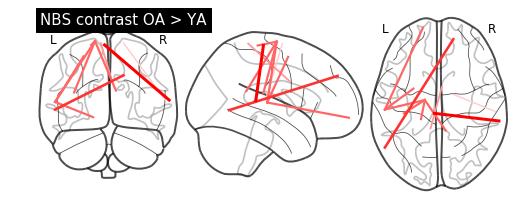

In [27]:
plotting.plot_connectome(adj, schaefer_coords, title='NBS contrast OA > YA', node_size=0)

### Create DMN mask

In [28]:
dmn_mask = np.r_[148:200,361:400]
a = np.zeros((400,400))
b = a[dmn_mask, :]
b = b[:, dmn_mask]
print(b.shape)

(91, 91)


In [29]:
print('Young Adults DMN')
print(X.shape)
X_dmn = []
X_dmn = X[dmn_mask,:,:]
X_dmn = X_dmn[:,dmn_mask,:]
print(X_dmn.shape)

print('Older Adults DMN')
print(Y.shape)
Y_dmn = []
Y_dmn = Y[dmn_mask,:,:]
Y_dmn = Y_dmn[:,dmn_mask,:]
print(Y_dmn.shape)

Young Adults DMN
(400, 400, 51)
(91, 91, 51)
Older Adults DMN
(400, 400, 53)
(91, 91, 53)


### BCT graph metrics by age group

In [30]:
thresh_range = [0.10, 0.15, 0.20, 0.25]

In [31]:
import bct
from bct import algorithms
import pandas as pd

for thresh in thresh_range:
    bct_data_oa = [] #just in case
    bct_data_oa = pd.DataFrame(columns = ('efficiency_global', 'clustering_coef', 'modularity', 'efficiency_global_dmn', 'clustering_coef_dmn', 'modularity_dmn'))
    for sub in range(0,np.ma.size(Y, 2)):
        thresh_mat = bct.threshold_proportional(Y[:,:,sub], thresh)      
        ge = algorithms.efficiency_wei(thresh_mat, local = False)
        cc = algorithms.clustering_coef_wu(thresh_mat).mean()
        Ci, Q = algorithms.modularity_und(thresh_mat)
        
        thresh_dmn = bct.threshold_proportional(Y_dmn[:,:,sub], thresh) 
        
        ge_dmn = algorithms.efficiency_wei(thresh_dmn, local = False)
        cc_dmn = algorithms.clustering_coef_wu(thresh_dmn).mean()
        Ci_dmn, Q_dmn = algorithms.modularity_und(thresh_dmn)
        
        bct_data_oa = bct_data_oa.append(pd.DataFrame({'efficiency_global': ge, 'clustering_coef': cc, 'modularity': Q, 'efficiency_global_dmn': ge_dmn, 'clustering_coef_dmn': cc_dmn, 'modularity_dmn': Q_dmn}, index=[0]), ignore_index=True)
    np.save('data/%s_bct_oa_thr_%s' % (task, str(thresh).split('.')[1]), bct_data_oa)
        
print(bct_data_oa[:5])


/usr/local/lib/python3.7/site-packages/bct/algorithms/clustering.py:216: RuntimeWarning: divide by zero encountered in true_divide
  C = cyc3 / (K * (K - 1))


   efficiency_global  clustering_coef  modularity  efficiency_global_dmn  \
0           0.465752         0.181291    0.067063               0.435365   
1           0.467175         0.183345    0.067895               0.440347   
2           0.465046         0.182216    0.065840               0.430387   
3           0.466466         0.183896    0.070314               0.440610   
4           0.466213         0.183477    0.069905               0.437168   

   clustering_coef_dmn  modularity_dmn  
0             0.189645        0.072009  
1             0.181481        0.078930  
2             0.187363        0.070498  
3             0.185647        0.080535  
4             0.188873        0.063401  


In [32]:
import bct
from bct import algorithms
import pandas as pd

thresh_range = [0.10, 0.15, 0.20, 0.25]
for thresh in thresh_range:
    bct_data_ya = [] #just in case
    bct_data_ya = pd.DataFrame(columns = ('efficiency_global', 'clustering_coef', 'modularity', 'efficiency_global_dmn', 'clustering_coef_dmn', 'modularity_dmn'))
    for sub in range(0,np.ma.size(X, 2)):
        thresh_mat = bct.threshold_proportional(X[:,:,sub], thresh)      
        ge = algorithms.efficiency_wei(thresh_mat, local = False)
        cc = algorithms.clustering_coef_wu(thresh_mat).mean()
        Ci, Q = algorithms.modularity_und(thresh_mat)
        
        thresh_dmn = bct.threshold_proportional(X_dmn[:,:,sub], thresh) 
        
        ge_dmn = algorithms.efficiency_wei(thresh_dmn, local = False)
        cc_dmn = algorithms.clustering_coef_wu(thresh_dmn).mean()
        Ci_dmn, Q_dmn = algorithms.modularity_und(thresh_dmn)
        
        bct_data_ya = bct_data_ya.append(pd.DataFrame({'efficiency_global': ge, 'clustering_coef': cc, 'modularity': Q, 'efficiency_global_dmn': ge_dmn, 'clustering_coef_dmn': cc_dmn, 'modularity_dmn': Q_dmn}, index=[0]), ignore_index=True)
    np.save('data/%s_bct_ya_thr_%s' % (task, str(thresh).split('.')[1]), bct_data_ya)
        
print(bct_data_ya[:5])


   efficiency_global  clustering_coef  modularity  efficiency_global_dmn  \
0           0.489300         0.222568    0.084000               0.474270   
1           0.489991         0.218301    0.085385               0.477638   
2           0.490144         0.219544    0.083590               0.475787   
3           0.490031         0.223281    0.083582               0.479910   
4           0.489668         0.220292    0.082117               0.476295   

   clustering_coef_dmn  modularity_dmn  
0             0.317881        0.109613  
1             0.370273        0.122392  
2             0.305963        0.123275  
3             0.301916        0.098801  
4             0.285300        0.100888  


In [33]:
from scipy import stats

t, p = stats.ttest_ind(bct_data_ya, bct_data_oa, equal_var=False)
print('global efficiency, clustering, modularity \n t-statistics: %s \n p-values: %s' %(t, p))

global efficiency, clustering, modularity 
 t-statistics: [242.14804276 105.71304242  38.48160824  72.18774067          nan
  22.2660515 ] 
 p-values: [6.00588091e-140 4.32356059e-091 2.94827354e-059 1.31016343e-085
             nan 4.70882150e-040]


/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


{'bodies': [<matplotlib.collections.PolyCollection at 0x14f42f2e8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x122844780>,
 'cmins': <matplotlib.collections.LineCollection at 0x14f42f780>,
 'cbars': <matplotlib.collections.LineCollection at 0x14f42f9e8>}

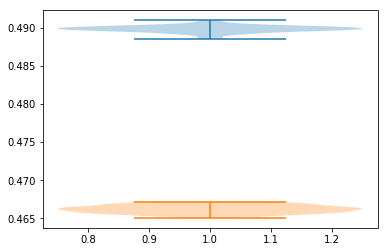

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.violinplot(bct_data_ya['efficiency_global'])
plt.violinplot(bct_data_oa['efficiency_global'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x1228a7080>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x12289b4a8>,
 'cmins': <matplotlib.collections.LineCollection at 0x12289beb8>,
 'cbars': <matplotlib.collections.LineCollection at 0x1228a7780>}

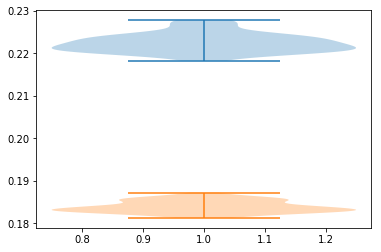

In [35]:
plt.violinplot(bct_data_ya['clustering_coef'])
plt.violinplot(bct_data_oa['clustering_coef'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x122d47668>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x122d39a90>,
 'cmins': <matplotlib.collections.LineCollection at 0x122d47b00>,
 'cbars': <matplotlib.collections.LineCollection at 0x122d47d68>}

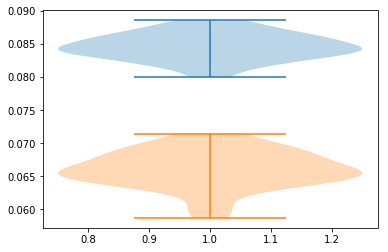

In [36]:
plt.violinplot(bct_data_ya['modularity'])
plt.violinplot(bct_data_oa['modularity'])